# Fusion de données

In [ ]:
#@title Lecture des données
import pandas as pd
import numpy as np
merged_df = pd.read_csv("new_data_concat.csv")

In [ ]:
#@title Taille de la base de données
len(merged_df)

5751809

In [ ]:
# Filtrer les lignes avec des quantités d'actes et des montants de dépense positifs
merged_df = merged_df[
    (merged_df['Quantité d\'acte - Prestation seule (pas presta. de réf.)'] > 0) &
    (merged_df['Montant de la dépense - Prestation seule'] > 0)
]

In [ ]:
#@title Quelques variables rajoutés (en se basant sur les indicateurs de fraudes)
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Calcul du Délai prescription-facturation (en mois)
merged_df['Délai prescription-facturation'] = (
    (merged_df['Année de remboursement'] - merged_df['Année de prescription']) * 12 +
    (merged_df['Mois de remboursement'] - merged_df['Mois de prescription'])
)

# Calcul des remboursements par mois
remboursements_par_mois = merged_df.groupby(
    ['N° PS exécutant Statistique', 'Année de remboursement', 'Mois de remboursement']
)['Nombre de bénéficiaires'].sum().reset_index(name='Bénéficiaires par mois')
merged_df = merged_df.merge(remboursements_par_mois, on=['N° PS exécutant Statistique', 'Année de remboursement', 'Mois de remboursement'])

# Calcul des dépenses par mois
depenses_par_mois = merged_df.groupby(
    ['N° PS exécutant Statistique', 'Année de remboursement', 'Mois de remboursement']
)['Montant de la dépense - Prestation seule'].sum().reset_index(name='Dépenses par mois')
# Fusion des dépenses par mois dans le DataFrame original
merged_df = merged_df.merge(depenses_par_mois, on=['N° PS exécutant Statistique', 'Année de remboursement', 'Mois de remboursement'])


# Calcul de la proportion de jeunes pour chaque 'N° PS exécutant Statistique'
proportion_jeunes = merged_df.groupby('N° PS exécutant Statistique')['Age du bénéficiaire'].apply(lambda x: (x < 18).mean())
merged_df = merged_df.merge(proportion_jeunes.rename('Proportion jeunes'), on='N° PS exécutant Statistique')

# Ajouter une colonne binaire 'Age supérieur à 18'
merged_df['Age supérieur à 18'] = (merged_df['Age du bénéficiaire'] > 18).astype(int)

In [ ]:
#@title Erreurs de saisie (délais)
# Filtrer les données pour retirer les délais supérieurs à 8 mois
merged_df = merged_df[merged_df['Délai prescription-facturation'] <= 8]

In [ ]:
#@title Nombre moyen de prescripteurs par établissement
merged_df['Prescripteurs par établissement'] = merged_df.groupby('Département du cabinet principal du PS exécutant')['N° PS prescripteur Statistique'].transform('nunique')

In [ ]:
#@title Proportion des prescripteurs par établissement
total_prescripteurs = merged_df.groupby('Département du cabinet principal du PS exécutant')['N° PS prescripteur Statistique'].transform('nunique')
merged_df['Proportion prescripteurs par établissement'] = 1 / total_prescripteurs

In [ ]:
#@title Moyenne d'âge par établissement
merged_df['Moyenne âge par établissement'] = (
    merged_df.groupby('N° PS exécutant Statistique')['Age du bénéficiaire']
    .transform('mean')
)

In [ ]:
#@title Spécialités 'MEDECINE GENERALE' et 'OTO RHINO-LARYNGOLOGIE'
merged_df = merged_df[
    merged_df["Libellé spécialité/nat. activité du PS prescripteur"].isin(["MEDECINE GENERALE", "OTO RHINO-LARYNGOLOGIE"])
]

# Compter le nombre d'occurrences de chaque spécialité par établissement
counts = merged_df.groupby(['N° PS exécutant Statistique',
                              "Libellé spécialité/nat. activité du PS prescripteur"]).size().reset_index(name='count')

# Obtenir le nombre total pour chaque établissement
total_counts = merged_df.groupby('N° PS exécutant Statistique').size().reset_index(name='total')

# Fusionner les deux DataFrame pour avoir une base de calcul
proportion_df = pd.merge(counts, total_counts, on='N° PS exécutant Statistique')

# Calculer la proportion pour chaque spécialité
proportion_df['proportion_med_gen'] = proportion_df.apply(lambda x: x['count'] / x['total'] if x['Libellé spécialité/nat. activité du PS prescripteur'] == "MEDECINE GENERALE" else 0, axis=1)
proportion_df['proportion_orl'] = proportion_df.apply(lambda x: x['count'] / x['total'] if x['Libellé spécialité/nat. activité du PS prescripteur'] == "OTO RHINO-LARYNGOLOGIE" else 0, axis=1)

# Agréger pour chaque établissement (somme par établissement)
proportion_aggregated = proportion_df.groupby('N° PS exécutant Statistique')[['proportion_med_gen', 'proportion_orl']].sum().reset_index()

# Fusionner les proportions calculées avec le DataFrame original
merged_df = pd.merge(merged_df, proportion_aggregated, on='N° PS exécutant Statistique', how='left')

In [ ]:
merged_df['proportion_med_gen'] = merged_df['proportion_med_gen'] * 100
merged_df['proportion_orl'] = merged_df['proportion_orl'] * 100
merged_df['difference_proportions'] = merged_df['proportion_orl']-merged_df['proportion_med_gen']

# Distances entre régions

In [ ]:
#@title Code régions

REGIONS = {
    'Auvergne-Rhône-Alpes': ['01', '03', '07', '15', '26', '38', '42', '43', '63', '69', '73', '74'],
    'Bourgogne-Franche-Comté': ['21', '25', '39', '58', '70', '71', '89', '90'],
    'Bretagne': ['35', '22', '56', '29'],
    'Centre-Val de Loire': ['18', '28', '36', '37', '41', '45'],
    'Corse': ['200', '201'],
    'Grand Est': ['08', '10', '51', '52', '54', '55', '57', '67', '68', '88'],
    'Guadeloupe': ['971'],
    'Guyane': ['973'],
    'Hauts-de-France': ['02', '59', '60', '62', '80'],
    'Île-de-France': ['75', '77', '78', '91', '92', '93', '94', '95'],
    'La Réunion': ['974'],
    'Martinique': ['972'],
    'Normandie': ['14', '27', '50', '61', '76'],
    'Nouvelle-Aquitaine': ['16', '17', '19', '23', '24', '33', '40', '47', '64', '79', '86', '87'],
    'Occitanie': ['09', '11', '12', '30', '31', '32', '34', '46', '48', '65', '66', '81', '82'],
    'Pays de la Loire': ['44', '49', '53', '72', '85'],
    'Provence-Alpes-Côte d\'Azur': ['04', '05', '06', '13', '83', '84'],
}

DEPARTMENTS = {
    '1': 'Ain',
    '2': 'Aisne',
    '3': 'Allier',
    '4': 'Alpes-de-Haute-Provence',
    '5': 'Hautes-Alpes',
    '6': 'Alpes-Maritimes',
    '7': 'Ardèche',
    '8': 'Ardennes',
    '9': 'Ariège',
    '10': 'Aube',
    '11': 'Aude',
    '12': 'Aveyron',
    '13': 'Bouches-du-Rhône',
    '14': 'Calvados',
    '15': 'Cantal',
    '16': 'Charente',
    '17': 'Charente-Maritime',
    '18': 'Cher',
    '19': 'Corrèze',
    '200': 'Corse-du-Sud',
    '201': 'Haute-Corse',
    '21': 'Côte-d\'Or',
    '22': 'Côtes-d\'Armor',
    '23': 'Creuse',
    '24': 'Dordogne',
    '25': 'Doubs',
    '26': 'Drôme',
    '27': 'Eure',
    '28': 'Eure-et-Loir',
    '29': 'Finistère',
    '30': 'Gard',
    '31': 'Haute-Garonne',
    '32': 'Gers',
    '33': 'Gironde',
    '34': 'Hérault',
    '35': 'Ille-et-Vilaine',
    '36': 'Indre',
    '37': 'Indre-et-Loire',
    '38': 'Isère',
    '39': 'Jura',
    '40': 'Landes',
    '41': 'Loir-et-Cher',
    '42': 'Loire',
    '43': 'Haute-Loire',
    '44': 'Loire-Atlantique',
    '45': 'Loiret',
    '46': 'Lot',
    '47': 'Lot-et-Garonne',
    '48': 'Lozère',
    '49': 'Maine-et-Loire',
    '50': 'Manche',
    '51': 'Marne',
    '52': 'Haute-Marne',
    '53': 'Mayenne',
    '54': 'Meurthe-et-Moselle',
    '55': 'Meuse',
    '56': 'Morbihan',
    '57': 'Moselle',
    '58': 'Nièvre',
    '59': 'Nord',
    '60': 'Oise',
    '61': 'Orne',
    '62': 'Pas-de-Calais',
    '63': 'Puy-de-Dôme',
    '64': 'Pyrénées-Atlantiques',
    '65': 'Hautes-Pyrénées',
    '66': 'Pyrénées-Orientales',
    '67': 'Bas-Rhin',
    '68': 'Haut-Rhin',
    '69': 'Rhône',
    '70': 'Haute-Saône',
    '71': 'Saône-et-Loire',
    '72': 'Sarthe',
    '73': 'Savoie',
    '74': 'Haute-Savoie',
    '75': 'Paris',
    '76': 'Seine-Maritime',
    '77': 'Seine-et-Marne',
    '78': 'Yvelines',
    '79': 'Deux-Sèvres',
    '80': 'Somme',
    '81': 'Tarn',
    '82': 'Tarn-et-Garonne',
    '83': 'Var',
    '84': 'Vaucluse',
    '85': 'Vendée',
    '86': 'Vienne',
    '87': 'Haute-Vienne',
    '88': 'Vosges',
    '89': 'Yonne',
    '90': 'Territoire de Belfort',
    '91': 'Essonne',
    '92': 'Hauts-de-Seine',
    '93': 'Seine-Saint-Denis',
    '94': 'Val-de-Marne',
    '95': 'Val-d\'Oise',
    '971': 'Guadeloupe',
    '972': 'Martinique',
    '973': 'Guyane',
    '974': 'La Réunion',
    '976': 'Mayotte',
}

In [ ]:
#@title Mappage des régions
def get_region(department):
    for region, departments in REGIONS.items():
        if department in departments:
            return region
    return None

# Département de l'exécutant
merged_df["Région du PS exécutant"] = merged_df["Département d'exercice du PS exécutant"].apply(get_region)
# Région du bénéficiaire
merged_df["Région du bénéficiaire"] = merged_df["Département du bénéficiaire"].apply(get_region)

In [ ]:
#@title Données localisation

coord_region = pd.read_csv('points-extremes-des-departements-metropolitains-de-france.csv', sep=',')
# Latitude et longitude moyenne
coord_region['Latitude moyenne'] = (
    (coord_region['Latitude la plus au nord'] + coord_region['Latitude la plus au sud']) / 2
)
coord_region['Longitude moyenne'] = (
    (coord_region['Longitude la plus à l’est'] + coord_region['Longitude la plus à l’ouest']) / 2
)

In [ ]:
departments_benef = coord_region.rename(columns={
    'Departement': 'Département du bénéficiaire',
    'Latitude moyenne': 'Latitude bénéficiaire',
    'Longitude moyenne': 'Longitude bénéficiaire'
})
departments_execut = coord_region.rename(columns={
    'Departement': 'Département d\'exercice du PS exécutant',
    'Latitude moyenne': 'Latitude exécutant',
    'Longitude moyenne': 'Longitude exécutant'
})

In [ ]:
departments_benef['Département du bénéficiaire'][departments_benef['Département du bénéficiaire']== '2A'] = "200"
departments_benef['Département du bénéficiaire'][departments_benef['Département du bénéficiaire']== '2B'] = "201"

departments_execut['Département d\'exercice du PS exécutant'][departments_execut['Département d\'exercice du PS exécutant']== '2A'] = "200"
departments_execut['Département d\'exercice du PS exécutant'][departments_execut['Département d\'exercice du PS exécutant']== '2B'] = "201"

<ipython-input-15-7b24c48e1a90>:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  departments_benef['Département du bénéficiaire'][departments_benef['Département du bénéficiaire']== '2A'] = "200"
<ipython-input-15-7b24c48e1a90>:1: SettingWith

In [ ]:
departments_benef['Département du bénéficiaire'] = departments_benef['Département du bénéficiaire'].astype(int)
departments_execut['Département d\'exercice du PS exécutant']= departments_execut['Département d\'exercice du PS exécutant'].astype(int)

In [ ]:
merged_df = merged_df.merge(departments_benef, on='Département du bénéficiaire', how='left')
merged_df = merged_df.merge(departments_execut, on='Département d\'exercice du PS exécutant', how='left')

In [ ]:
#@title calcul la distance beneficiare - etablissement
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Rayon de la Terre en km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Appliquer la fonction vectorisée
merged_df['Distance benef ex (km)'] = haversine(
    merged_df['Latitude bénéficiaire'],
    merged_df['Longitude bénéficiaire'],
    merged_df['Latitude exécutant'],
    merged_df['Longitude exécutant']
)

In [ ]:
#@title Distributions des distances
merged_df['Distance benef ex (km)'].value_counts()

,count
Distance benef ex (km),
0.000000,3433801
9.209367,15152
7.951008,13657
12.650608,10670
54.799652,8254
...,...
447.013197,1
552.906542,1
979.745351,1


In [ ]:
#@title  Filtre sur les distances
merged_df['Distance benef ex (km)'] = merged_df['Distance benef ex (km)'].apply(
    lambda x: 0 if x < 50 else x * 1000
)

In [ ]:
#@title Modele de détéction d'**anomalies**

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Sélection des colonnes pertinentes
features = [
    'Délai prescription-facturation',
    'Bénéficiaires par mois',
    'Dépenses par mois',
    'Quantité d\'acte - Prestation seule (pas presta. de réf.)',
    'Montant de la dépense - Prestation seule',
    'Proportion jeunes',
    'Age supérieur à 18',
    'Prescripteurs par établissement',
    'Moyenne âge par établissement',
    'proportion_med_gen',
    'proportion_orl',
    'difference_proportions',
    'Distance benef ex (km)'
]

# Remplir les valeurs manquantes avec la moyenne de chaque colonne (si nécessaire)
merged_df[features] = merged_df[features].fillna(merged_df[features].mean())

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_df[features])

# Application de l'Isolation Forest
model = IsolationForest(contamination=0.01, random_state=42)
merged_df['Fraude_anomalie'] = model.fit_predict(X_scaled)


In [ ]:
#@title Vue générale des résultats
# Les anomalies seront marquées par -1, et les données normales par 1
merged_df['Fraude_anomalie'] = merged_df['Fraude_anomalie'].map({1: 0, -1: 1})  # 0 pour normal, 1 pour fraude

# Affichage du nombre d'anomalies détectées
print(f"Nombre d'anomalies détectées : {merged_df['Fraude_anomalie'].sum()}")

Nombre d'anomalies détectées : 39423


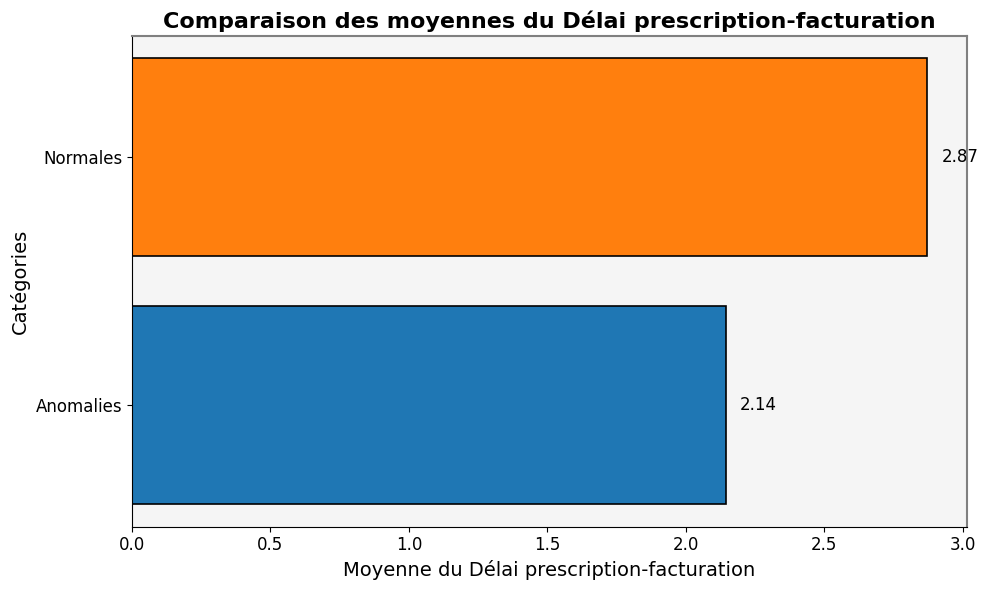

In [ ]:
#@title Délai prescription-facturation (généralement courtes pour les fraudes!)
import matplotlib.pyplot as plt
import pandas as pd

# Comparaison des moyennes des variables pour les anomalies et les normales
anomalies = merged_df[merged_df['Fraude_anomalie'] == 1]
normales = merged_df[merged_df['Fraude_anomalie'] == 0]

# Calcul des moyennes
mean_anomalies = anomalies['Délai prescription-facturation'].mean()
mean_normales = normales['Délai prescription-facturation'].mean()

# Préparer les données pour le graphique
categories = ['Anomalies', 'Normales']
means = [mean_anomalies, mean_normales]

# Création du graphique barh
plt.figure(figsize=(10, 6))

# Choisir un jeu de couleurs stylé
colors = ['#1f77b4', '#ff7f0e']

# Tracer le graphique en barh
bars = plt.barh(categories, means, color=colors, edgecolor='black', linewidth=1.2)

# Ajouter des labels sur les barres
for bar in bars:
    plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}', va='center', ha='left', fontsize=12, color='black')

# Ajouter des titres et des labels
plt.xlabel("Moyenne du Délai prescription-facturation", fontsize=14)
plt.ylabel("Catégories", fontsize=14)
plt.title("Comparaison des moyennes du Délai prescription-facturation", fontsize=16, fontweight='bold')

# Personnaliser les axes et l'apparence
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Ajouter un fond et des bordures stylisées
plt.gca().set_facecolor('whitesmoke')
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['top'].set_color('gray')
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['right'].set_color('gray')

# Afficher le graphique
plt.tight_layout()
plt.show()

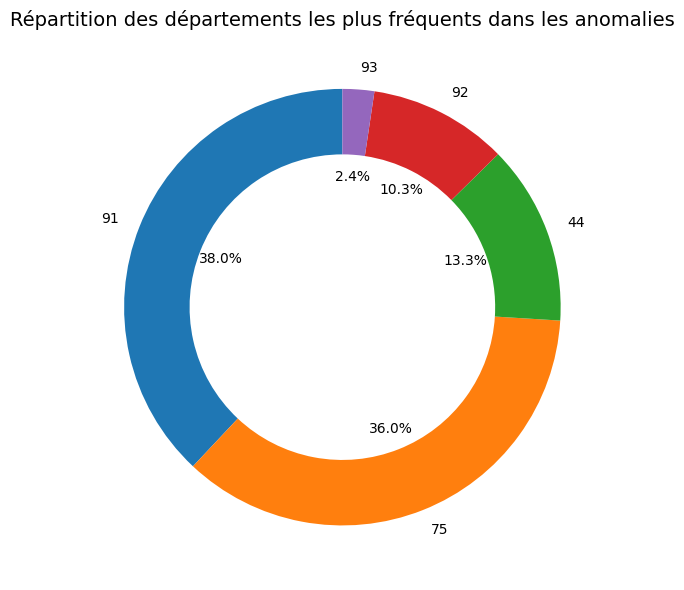

In [ ]:
#@title Départements fréquents dans les anomalies détectées

import matplotlib.pyplot as plt

# Comptage des départements les plus fréquents dans anomalies
top_departments = anomalies['Département d\'exercice du PS exécutant'].value_counts().head(5)

# Création du donut chart
plt.figure(figsize=(8, 6))
plt.pie(top_departments, labels=top_departments.index, autopct='%1.1f%%', startangle=90, wedgeprops={'width': 0.3})

# Ajouter un cercle au centre pour créer l'effet donut
centre_circle = plt.Circle((0, 0), 0.50, color='white', fc='white', lw=0)
plt.gca().add_artist(centre_circle)

# Ajouter un titre
plt.title("Répartition des départements les plus fréquents dans les anomalies", fontsize=14)

# Afficher le graphique
plt.tight_layout()
plt.show()


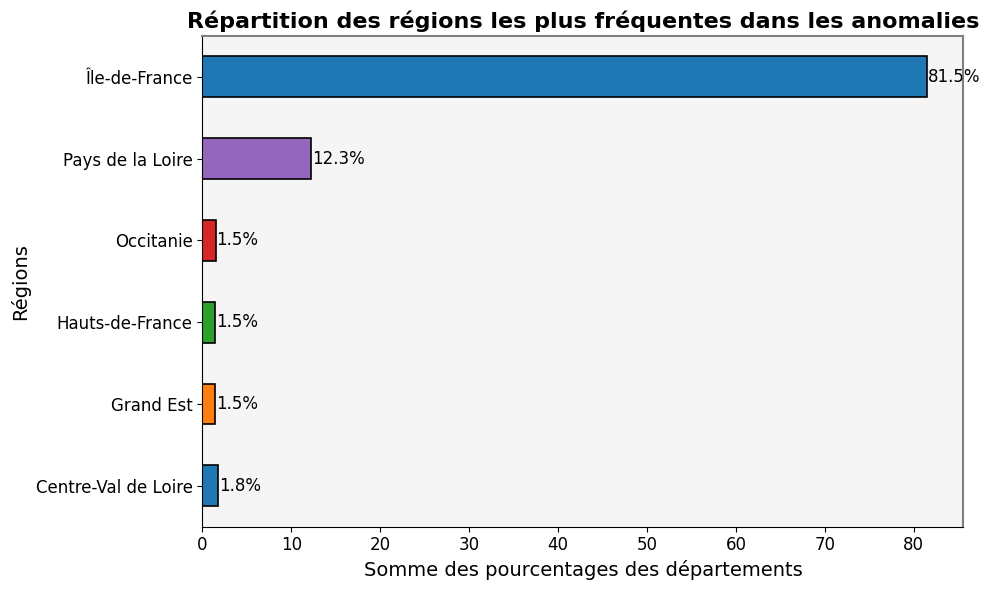

In [ ]:
#@title departement_to_region
departement_to_region = {
    '01': 'Auvergne-Rhône-Alpes',
    '02': 'Hauts-de-France',
    '03': 'Auvergne-Rhône-Alpes',
    '04': 'Provence-Alpes-Côte d\'Azur',
    '05': 'Provence-Alpes-Côte d\'Azur',
    '06': 'Provence-Alpes-Côte d\'Azur',
    '07': 'Auvergne-Rhône-Alpes',
    '08': 'Grand Est',
    '09': 'Occitanie',
    '10': 'Grand Est',
    '11': 'Occitanie',
    '12': 'Occitanie',
    '13': 'Provence-Alpes-Côte d\'Azur',
    '14': 'Normandie',
    '15': 'Auvergne-Rhône-Alpes',
    '16': 'Nouvelle-Aquitaine',
    '17': 'Nouvelle-Aquitaine',
    '18': 'Centre-Val de Loire',
    '19': 'Nouvelle-Aquitaine',
    '20': 'Corse',
    '21': 'Bourgogne-Franche-Comté',
    '22': 'Bretagne',
    '23': 'Nouvelle-Aquitaine',
    '24': 'Nouvelle-Aquitaine',
    '25': 'Bourgogne-Franche-Comté',
    '26': 'Auvergne-Rhône-Alpes',
    '27': 'Normandie',
    '28': 'Centre-Val de Loire',
    '29': 'Bretagne',
    '30': 'Occitanie',
    '31': 'Occitanie',
    '32': 'Occitanie',
    '33': 'Nouvelle-Aquitaine',
    '34': 'Occitanie',
    '35': 'Bretagne',
    '36': 'Centre-Val de Loire',
    '37': 'Centre-Val de Loire',
    '38': 'Auvergne-Rhône-Alpes',
    '39': 'Bourgogne-Franche-Comté',
    '40': 'Nouvelle-Aquitaine',
    '41': 'Centre-Val de Loire',
    '42': 'Auvergne-Rhône-Alpes',
    '43': 'Auvergne-Rhône-Alpes',
    '44': 'Pays de la Loire',
    '45': 'Centre-Val de Loire',
    '46': 'Occitanie',
    '47': 'Nouvelle-Aquitaine',
    '48': 'Occitanie',
    '49': 'Pays de la Loire',
    '50': 'Normandie',
    '51': 'Grand Est',
    '52': 'Grand Est',
    '53': 'Pays de la Loire',
    '54': 'Grand Est',
    '55': 'Grand Est',
    '56': 'Bretagne',
    '57': 'Grand Est',
    '58': 'Bourgogne-Franche-Comté',
    '59': 'Hauts-de-France',
    '60': 'Hauts-de-France',
    '61': 'Normandie',
    '62': 'Hauts-de-France',
    '63': 'Auvergne-Rhône-Alpes',
    '64': 'Nouvelle-Aquitaine',
    '65': 'Occitanie',
    '66': 'Occitanie',
    '67': 'Grand Est',
    '68': 'Grand Est',
    '69': 'Auvergne-Rhône-Alpes',
    '70': 'Bourgogne-Franche-Comté',
    '71': 'Bourgogne-Franche-Comté',
    '72': 'Pays de la Loire',
    '73': 'Auvergne-Rhône-Alpes',
    '74': 'Auvergne-Rhône-Alpes',
    '75': 'Île-de-France',
    '76': 'Normandie',
    '77': 'Île-de-France',
    '78': 'Île-de-France',
    '79': 'Nouvelle-Aquitaine',
    '80': 'Hauts-de-France',
    '81': 'Occitanie',
    '82': 'Occitanie',
    '83': 'Provence-Alpes-Côte d\'Azur',
    '84': 'Provence-Alpes-Côte d\'Azur',
    '85': 'Pays de la Loire',
    '86': 'Nouvelle-Aquitaine',
    '87': 'Nouvelle-Aquitaine',
    '88': 'Grand Est',
    '89': 'Bourgogne-Franche-Comté',
    '90': 'Bourgogne-Franche-Comté',
    '91': 'Île-de-France',
    '92': 'Île-de-France',
    '93': 'Île-de-France',
    '94': 'Île-de-France',
    '95': 'Île-de-France',
    '96': 'Outre-mer',
    '97': 'Outre-mer',
    '98': 'Outre-mer',
    '99': 'Outre-mer',
}

# Comptage des départements les plus fréquents dans anomalies
top_departments = anomalies['Département d\'exercice du PS exécutant'].value_counts().head(10)

# Mappage des départements vers les régions
top_departments_regions = top_departments.index.astype(str).map(departement_to_region)

# Comptage des régions les plus fréquentes dans anomalies (après mappage)
region_counts = top_departments_regions.value_counts()

# Mappage des départements aux régions
department_to_region = top_departments.index.to_series().map(departement_to_region)

# Calcul de la somme des pourcentages des départements dans chaque région
region_percentage = top_departments.groupby(top_departments_regions).sum() / top_departments.sum() * 100

# Création du barh chart pour les régions
plt.figure(figsize=(10, 6))

# Choisir un jeu de couleurs stylé
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Tracer le graphique en barh
bars = region_percentage.plot(kind='barh', color=colors, edgecolor='black', linewidth=1.2)

# Ajouter des labels sur les barres
for index, value in enumerate(region_percentage):
    # Ajouter l'étiquette dans la barre, avec la somme des pourcentages des départements
    plt.text(value + 0.1, index, f'{value:.1f}%', va='center', ha='left', fontsize=12, color='black')

# Ajouter des titres et des labels
plt.xlabel("Somme des pourcentages des départements", fontsize=14)
plt.ylabel("Régions", fontsize=14)
plt.title("Répartition des régions les plus fréquentes dans les anomalies", fontsize=16, fontweight='bold')

# Personnaliser les axes et l'apparence
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Ajouter un fond et des bordures stylisées
plt.gca().set_facecolor('whitesmoke')
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['top'].set_color('gray')
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['right'].set_color('gray')

# Afficher le graphique
plt.tight_layout()
plt.show()


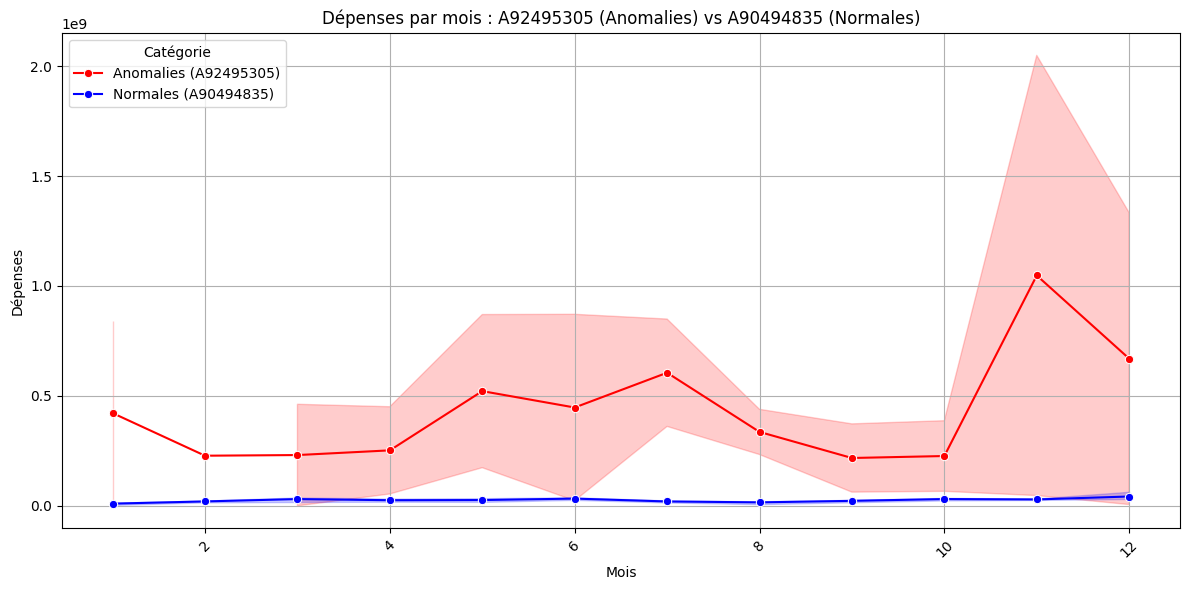

Établissement le plus fréquent dans les anomalies : A92495305
Établissement le plus fréquent dans les normales : A90494835


In [ ]:
#@title Exemple de détéction (à vérifier)

import seaborn as sns
import matplotlib.pyplot as plt

# Sélectionner l'établissement le plus fréquent dans les anomalies et les normales
etablissement_anomalie_id = anomalies['N° PS exécutant Statistique'].value_counts().idxmax()  # L'établissement le plus fréquent dans les anomalies
etablissement_normal_id = normales['N° PS exécutant Statistique'].value_counts().idxmax()  # L'établissement le plus fréquent dans les normales

# Filtrer les données pour ces deux établissements
anomalies_etablissement = anomalies[anomalies['N° PS exécutant Statistique'] == etablissement_anomalie_id]
normales_etablissement = normales[normales['N° PS exécutant Statistique'] == etablissement_normal_id]

# Calculer les remboursements totaux par mois pour anomalies et normales
anomalies_mois = anomalies_etablissement.groupby(['Année de remboursement', 'Mois de remboursement'])['Dépenses par mois'].sum().reset_index()
normales_mois = normales_etablissement.groupby(['Année de remboursement', 'Mois de remboursement'])['Dépenses par mois'].sum().reset_index()

# Créer un graphique
plt.figure(figsize=(12, 6))

# Tracer les remboursements pour l'établissement avec anomalies
sns.lineplot(data=anomalies_mois, x='Mois de remboursement', y='Dépenses par mois', label=f'Anomalies ({etablissement_anomalie_id})', color='red', marker='o')

# Tracer les remboursements pour l'établissement normal
sns.lineplot(data=normales_mois, x='Mois de remboursement', y='Dépenses par mois', label=f'Normales ({etablissement_normal_id})', color='blue', marker='o')

# Ajouter des détails au graphique
plt.title(f'Dépenses par mois : {etablissement_anomalie_id} (Anomalies) vs {etablissement_normal_id} (Normales)')
plt.xlabel('Mois')
plt.ylabel('Dépenses')
plt.legend(title='Catégorie', loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)

# Afficher le graphique
plt.tight_layout()
plt.show()

# Affichage des établissements sélectionnés pour confirmation
print(f"Établissement le plus fréquent dans les anomalies : {etablissement_anomalie_id}")
print(f"Établissement le plus fréquent dans les normales : {etablissement_normal_id}")



In [ ]:
anomalies['Distance benef ex (km)']= anomalies['Distance benef ex (km)']/1000

<ipython-input-55-e2ce125c0013>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['Distance benef ex (km)']= anomalies['Distance benef ex (km)']/1000


In [ ]:
anomalies['Distance benef ex (km)'].value_counts()

,count
Distance benef ex (km),
0.000000,14559
231.466946,1835
220.716056,1114
53.216835,671
158.388352,636
...,...
385.784311,1
89.542321,1
507.087990,1


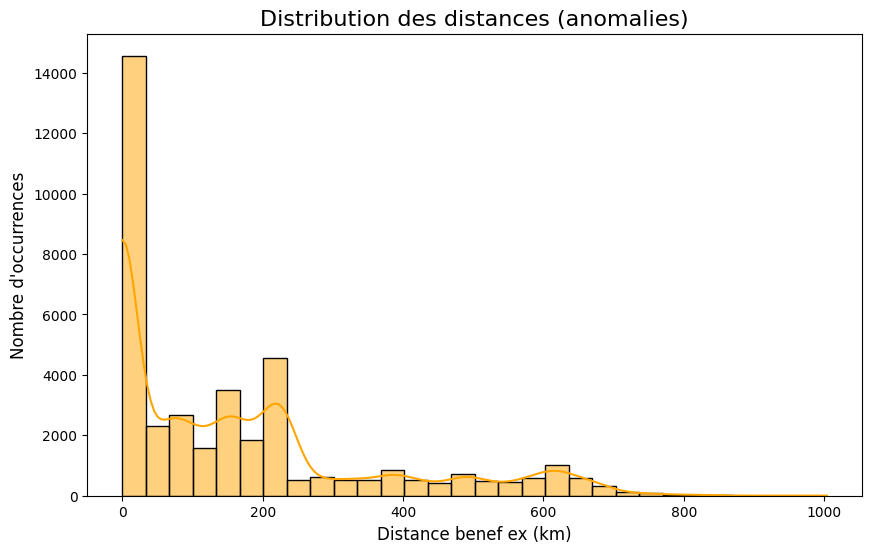

In [ ]:
# Distribution des distances dans les anomalies
plt.figure(figsize=(10, 6))
sns.histplot(anomalies['Distance benef ex (km)'], bins=30, kde=True, color='orange')
plt.title("Distribution des distances (anomalies)", fontsize=16)
plt.xlabel("Distance benef ex (km)", fontsize=12)
plt.ylabel("Nombre d'occurrences", fontsize=12)
plt.show()


Shape de X_scaled: (3942359, 13)
Longueur de features: 13


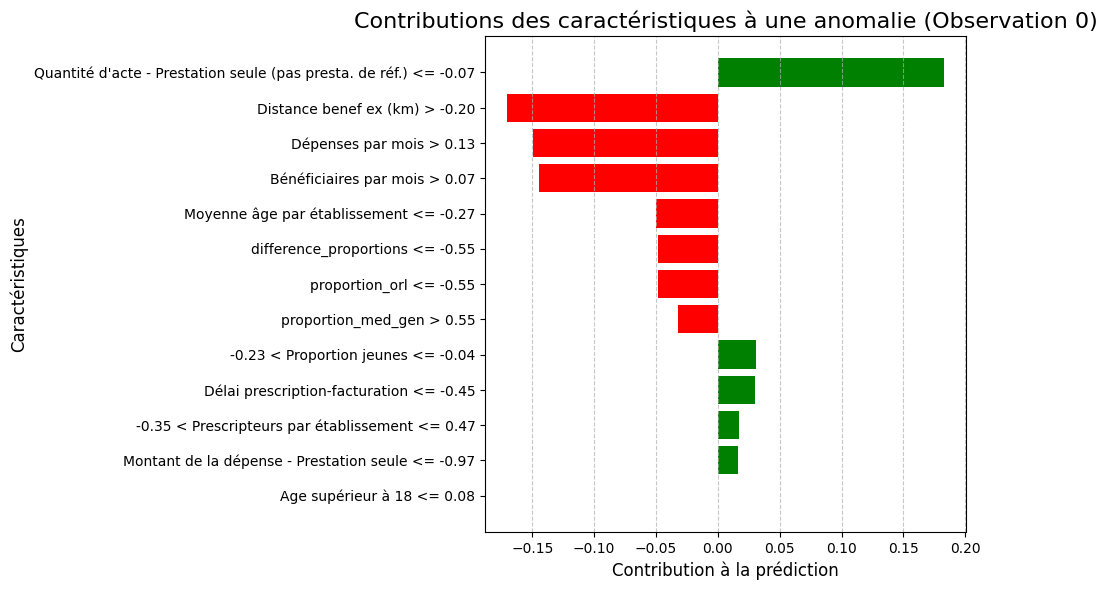

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import numpy as np

# Assurez-vous que 'features' correspond exactement à la taille de 'X_scaled'
features = [
    'Délai prescription-facturation',
    'Bénéficiaires par mois',
    'Dépenses par mois',
    'Quantité d\'acte - Prestation seule (pas presta. de réf.)',
    'Montant de la dépense - Prestation seule',
    'Proportion jeunes',
    'Age supérieur à 18',
    'Prescripteurs par établissement',
    'Moyenne âge par établissement',
    'proportion_med_gen',
    'proportion_orl',
    'difference_proportions',
    'Distance benef ex (km)'
]

# Vérifiez que la taille de X_scaled est bien la même que la longueur de features
print("Shape de X_scaled:", X_scaled.shape)
print("Longueur de features:", len(features))

# Filtrer les anomalies et les données normalisées
anomalies_scaled = X_scaled[merged_df['Fraude_anomalie'] == 1]
anomalies_df = merged_df[merged_df['Fraude_anomalie'] == 1]

# Vérification si des anomalies existent
if anomalies_scaled.shape[0] == 0:
    print("Aucune anomalie détectée.")
else:
    # Création de l'explainer LIME avec les données des anomalies uniquement
    explainer = LimeTabularExplainer(
        training_data=X_scaled,  # Utilisation de l'ensemble de données standardisé pour l'explication
        mode="classification",  # Mode classification
        feature_names=features,  # Vérifiez que cette liste correspond au nombre de colonnes dans X_scaled
        discretize_continuous=True,
        random_state=42
    )

    # Sélection d'une anomalie spécifique (par exemple, la première anomalie)
    observation_index = 0  # Vous pouvez ajuster cet index pour explorer d'autres anomalies
    observation = anomalies_scaled[observation_index].reshape(1, -1)

    # Fonction de prédiction pour LIME
    def predict_proba(X):
        try:
            # Retourner les probabilités directement si disponibles
            if hasattr(model, "predict_proba"):
                return model.predict_proba(X)
            # Sinon, calculer des probabilités à partir des scores de décision
            elif hasattr(model, "decision_function"):
                scores = model.decision_function(X)
                probas = (scores - scores.min()) / (scores.max() - scores.min())
                return np.vstack([1 - probas, probas]).T
            else:
                raise AttributeError("Le modèle doit implémenter 'predict_proba' ou 'decision_function'.")
        except Exception as e:
            print(f"Erreur lors de la génération des probabilités : {e}")
            return None

    # Générer une explication pour l'observation
    exp = explainer.explain_instance(
        data_row=observation.flatten(),  # Observation à expliquer
        predict_fn=predict_proba,  # Fonction de prédiction
        num_features=13)

    # Afficher les contributions des caractéristiques
    feature_contributions = exp.as_list()

    # Extraire les noms des caractéristiques et leurs contributions
    feature_names, contributions = zip(*feature_contributions)

    # Création du barplot
    plt.figure(figsize=(10, 6))
    colors = ['green' if value > 0 else 'red' for value in contributions]  # Vert : contribution positive, rouge : négative
    plt.barh(feature_names, contributions, color=colors)

    # Ajouter les labels et le titre
    plt.xlabel("Contribution à la prédiction", fontsize=12)
    plt.ylabel("Caractéristiques", fontsize=12)
    plt.title(f"Contributions des caractéristiques à une anomalie (Observation {observation_index})", fontsize=16)
    plt.gca().invert_yaxis()  # Inverser l'axe Y
    plt.grid(axis="x", linestyle="--", alpha=0.7)

    # Afficher le graphe
    plt.tight_layout()
    plt.show()


In [ ]:
anomalies.head(1)

,Année de remboursement,Mois de remboursement,N° PS prescripteur Statistique,Libellé spécialité/nat. activité du PS prescripteur,Département du cabinet principal du PS Prescripteur,Année de prescription,Mois de prescription,N° PS exécutant Statistique,Catégorie du PS exécutant,Département du cabinet principal du PS exécutant,...,Latitude bénéficiaire,Longitude bénéficiaire,Latitude la plus au nord_y,Latitude la plus au sud_y,Longitude la plus à l’est_y,Longitude la plus à l’ouest_y,Latitude exécutant,Longitude exécutant,Distance benef ex (km),Fraude_anomalie
956,2021,4,A03334694,MEDECINE GENERALE,2,2021,4,A92495305,2,91,...,49.453534,3.608257,48.776102,48.284689,2.585374,1.91492,48.530395,2.250147,142.668612,1


In [ ]:
# prompt: anomalies to csv

anomalies.to_csv('anomalies.csv', index=False)
from google.colab import files
files.download('anomalies.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>